# Structural Imbalance with the D-Wave System
In the [structural imbalance demo](https://cloud.dwavesys.com/leap/demos/socialnetwork/) you saw how Juliet’s new love of Romeo introduced imbalance into the social network of Verona.   
<img src="images/Romeo.png" width=250x/>

This notebook examines how you can solve optimization problems on a  D-Wave quantum processing unit (QPU) with the example of a structural imbalance problem.

1. [What is Structural Imbalance?](#What-is-Structural-Imbalance?) defines and explains the structural imbalance problem.

2. [Formulating the Problem](#Formulating-the-Problem-for-a-D-Wave-System) shows how such optimization problems can be formulated for solution on a quantum computer. 
3. [A Toy Example](#A-Toy-Example) codes a small structural imbalance problem to demonstrate the solution technique. 
3. [A Real-World Example](#A-Real-World-Example) applies the solution to the data sets of the Stanford Militants Mapping Project.

This notebook should help you understand both the techniques and [Ocean software](https://github.com/dwavesystems) tools used for solving optimization problems on D-Wave quantum computers.

**New to Jupyter Notebooks?** JNs are divided into text or code cells. Pressing the **Run** button in the menu bar moves to the next cell. Code cells are marked by an "In: \[\]" to the left; when run, an asterisk displays until code completion: "In: \[\*\]".

# What is Structural Imbalance?
Let's first define the problem of estimating structural imbalance for real-world social networks.

*Social networks* map relationships between people or organizations onto graphs, with
the people/organizations as nodes and relationships as edges; for example,
Facebook friends form a social network. *Signed social networks* map both friendly and
hostile relationships by assigning to edges either positive or negative values. Such networks are said to be *structurally balanced* when they can be cleanly divided into two sets, with each set containing only friends, and all relations between these sets are hostile. The measure of *structural imbalance* or *frustration* for a signed social network, when it cannot be cleanly divided, is the minimum number of edges that violate the social rule, “the enemy of my friend is my enemy.”

Finding a division that minimizes frustration is an NP-hard graph problem (it can be viewed as an expansion of the well-known [maximum cut](https://en.wikipedia.org/wiki/Maximum_cut) problem). This is an example of a broad class of optimization problems well-suited to solution on D-Wave systems. Other examples include protein folding, traffic flow optimization, job-shop scheduling, and many more.  

# Formulating the Problem for a D-Wave System
How can we formulate this problem for a D-Wave quantum computer to solve? 

D-Wave systems solve Ising problems: given $N$ variables $s_1,...,s_N$, where each variable $s_i$ can have values $-1$ or $+1$, the system finds assignments of values that minimize 

  $\sum_{i=1}^N h_i s_i +
  \sum_{i<j}^N J_{i,j} s_i s_j$,

where $h_i$ and $J_{i,j}$ are configurable (linear and quadratic) coefficients. To formulate a problem for the D-Wave system is to program $h_i$ and $J_{i,j}$ so that assignments of $s_1, ..., s_N$ that minimize this summation also represent solutions to the problem. 

In our case, variables $s_i$ can represent people, with values $-1,+1$ denoting a person's assignment to one of the two sets we want to divide the social network into. If we set $J_{i,j}$ to $-1$ for friendly $s_is_j$ pairs and $+1$ for hostile pairs, their multiplication takes values

$J_{i,j} s_i s_j=
\begin{cases} 
      -1 & \text{friends in same set (} s_i=s_j \text{) or enemies in different sets ($s_i \ne s_j$)} \\
      +1 & \text{friends in different sets ($s_i \ne s_j$) or enemies in same set ($s_i=s_j$)} 
\end{cases}
$

The summation $\sum_{i<j}^N J_{i,j} s_i s_j$ now decrements when an assignment contributes to balance and increments when it contributes to frustration.

You can see this in the graphic below, which shows all possible combinations of a two-nodes signed social network. People in the $-1$ set are shown as yellow dots, the $+1$ set as blue dots. Friendly relationships are shown as green edges, hostile as red. 

<img src="images/TwoNodes_AllCombinations.png" width=450x/>

If we set $h_i=0$, the Ising model is just $\sum_{i<j}^N J_{i,j} s_i s_j$. Programmed with these coefficients for a given signed social network, the quantum computer finds partitions (assignments of $s_i$) that minimize frustration. 

This is an example of a technique called a *penalty model*, where a problem is formulated so that undesired outcomes are penalized by being assigned higher values in the term being minimized. D-Wave documentation describes this and various other techniques for formulating optimization problems for solution on the quantum computer.

In [79]:
import matplotlib.pyplot as plt
import networkx as nx
import random

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx
import time

from sklearn.linear_model import LinearRegression

## A Toy Example

The code in this section demonstrates the use of Ocean software on a small social network. The next section implements the solution on a real-world problem. 

The first code cell creates a K4 complete social graph (each one of four people is connected to the other three). Relationships between the four are set randomly to friend or enemy each time you execute the code (by pressing the **Run** button with your mouse in the cell--try it a few times). 

Friendly relationships:  [('Alice', 'Bob', -1), ('Alice', 'Eve', -1), ('Bob', 'Wally', -1)]
Hostile relationships:  [('Alice', 'Wally', 1), ('Bob', 'Eve', 1), ('Eve', 'Wally', 1)]


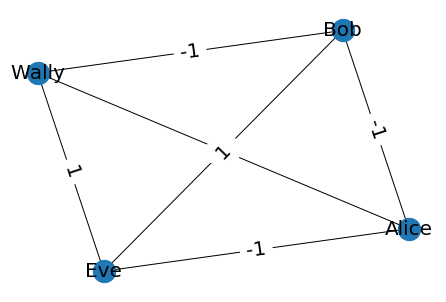

In [30]:
# Use NetworkX graphic package and Python's random library to create a randomly signed network

# Create a K4 complete graph (default node labels are indexical from 0)
G = nx.complete_graph(4)
# Randomly assign +1 or -1 relationship signs to all edges. Rename node 0 to Alice, 1 to Bob, etc
G.add_edges_from([(u, v, {'sign': 2*random.randint(0, 1)-1}) for u, v in G.edges])
nx.relabel_nodes(G, {0: 'Alice', 1: 'Bob', 2: 'Eve', 3: 'Wally'}, copy=False)

# Print the relationships assigned by the current code execution
print('Friendly relationships: ', [(x, y, sign) for (x, y, sign) in G.edges(data='sign') if (sign == -1)])
print('Hostile relationships: ', [(x, y, sign) for (x, y, sign) in G.edges(data='sign') if (sign == 1)])

pos = nx.spring_layout(G)

nx.draw(G, pos)#, with_labels=True)
nx.draw_networkx_labels(G,pos=pos, font_size=20)
labels = nx.get_edge_attributes(G,'sign')

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=20)
nx.draw_networkx_nodes(G,pos,node_size=500)

plt.show()

### Setting Up a Solver
A solver is a resource that runs problems; for example, a D-Wave system. Typically with Ocean tools you configure a default solver and that configuration is used implicitly (for example, your API token for authentication). Occasionally you may wish to override a default and specify particular solver settings.

The cell below displays your default solver configuration. The next cell allows you to explicitly select a solver and API token.

Your default or manually set solver and token are used in the next cell. The cell sets a *sampler*, the component used to find variable values that minimize the Ising model representing our problem. Here we use a D-Wave system (the `solver={'qpu': True}` argument) but Ocean tools are designed to swap in and out samplers with ease. For example you might first run a classical sampler on your computer's CPU during testing, and only once your code is ready, submit the problem for solution on the quantum computer.   

*DWaveSampler()* from Ocean software's [dwave-system](https://docs.ocean.dwavesys.com/projects/system/en/latest/) tool handles the connection to a D-Wave system. This tool also handles mapping between the graph of our problem, NetworkX's *complete_graph(4)* graph with nodes labeled Alice, Bob etc, to the D-Wave QPU's numerically indexed qubits. This mapping, known as *minor-embedding*, is done by the *EmbeddingComposite()* composite.   

In [39]:
# sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))  # Some accounts need to replace this line with the next:
sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_2_1', token=''))

### Solving the Problem
Next, the *structural_imbalance()* algorithm, from Ocean's [dwave_networkx](https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/latest/) extension of the NetworkX graphic package, submits the Ising model we formulated in the previous section to a D-Wave system. It returns a partition of our social network into two colored sets and the frustrated edges.

sovled in  2.552739381790161 s
Yellow set:  ['Bob', 'Eve']
Blue set:  ['Alice', 'Wally']

Frustrated relationships:  [('Eve', 'Wally')]


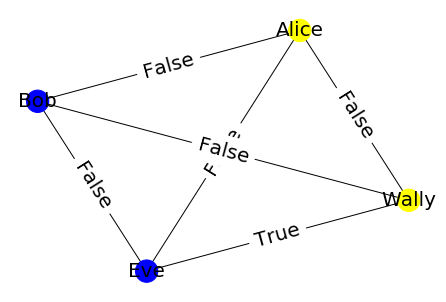

Friendly relationships:  [('Alice', 'Wally'), ('Bob', 'Eve'), ('Eve', 'Wally')]
Hostile relationships:  [('Alice', 'Bob'), ('Alice', 'Eve'), ('Bob', 'Wally')]


In [33]:
# Return a good partition (minimal structural imbalance) and its frustrated edges  
start = time.time()

imbalance, bicoloring = dnx.structural_imbalance(G, sampler)

end = time.time()
print('sovled in ', end-start, 's')
# Mark the returned frustrated edges and node set (color) on the graph 
for edge in G.edges:
    G.edges[edge]['frustrated'] = edge in imbalance
for node in G.nodes:
    G.nodes[node]['color'] = bicoloring[node]

# Print the relationships for the returned partition
print('Yellow set: ', [person for (person, color) in bicoloring.items() if (color == 0)])
print('Blue set: ', [person for (person, color) in bicoloring.items() if (color == 1)])
print('\nFrustrated relationships: ', list(imbalance.keys()))

pos = nx.spring_layout(G)

nx.draw(G, pos)#, with_labels=True)
nx.draw_networkx_labels(G,pos=pos, font_size=20)
labels = nx.get_edge_attributes(G,'frustrated')
node_color = nx.get_node_attributes(G, 'color')
color_map = ['yellow' if color==1 else 'blue'
            for name, color in node_color.items()]


nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=20)
nx.draw_networkx_nodes(G,pos,node_size=500, node_color=color_map)

plt.show()

### All friendly

Friendly relationships:  [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Hostile relationships:  []


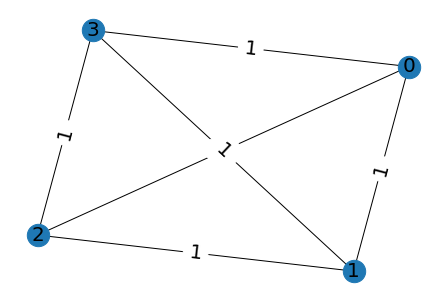

sovled in  0.803203821182251 s
Yellow set:  [0, 1, 2, 3]
Blue set:  []

Frustrated relationships:  []


/home/matthias/Documents/dsenv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


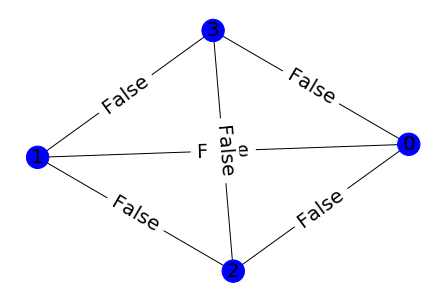

In [54]:
# Use NetworkX graphic package and Python's random library to create a randomly signed network

# Create a K4 complete graph (default node labels are indexical from 0)
G = nx.complete_graph(4)
# Randomly assign +1 or -1 relationship signs to all edges. Rename node 0 to Alice, 1 to Bob, etc
G.add_edges_from([(u, v, {'sign': 1}) for u, v in G.edges])
# nx.relabel_nodes(G, {0: 'Alice', 1: 'Bob', 2: 'Eve', 3: 'Wally'}, copy=False)

# Print the relationships assigned by the current code execution
print('Friendly relationships: ', [(x, y) for (x, y, sign) in G.edges(data='sign') if (sign == 1)])
print('Hostile relationships: ', [(x, y) for (x, y, sign) in G.edges(data='sign') if (sign == -1)])

pos = nx.spring_layout(G)

nx.draw(G, pos)#, with_labels=True)
nx.draw_networkx_labels(G,pos=pos, font_size=20)
labels = nx.get_edge_attributes(G,'sign')

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=20)
nx.draw_networkx_nodes(G,pos,node_size=500)

plt.show()


# sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))  # Some accounts need to replace this line with the next:
sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_2_1', token='DEV-a3ae2d86bfa91d5114e454b0f1431256139b710f'))

# Return a good partition (minimal structural imbalance) and its frustrated edges  
start = time.time()

imbalance, bicoloring = dnx.structural_imbalance(G, sampler)

end = time.time()
print('sovled in ', end-start, 's')
# Mark the returned frustrated edges and node set (color) on the graph 
for edge in G.edges:
    G.edges[edge]['frustrated'] = edge in imbalance
for node in G.nodes:
    G.nodes[node]['color'] = bicoloring[node]

# Print the relationships for the returned partition
print('Yellow set: ', [person for (person, color) in bicoloring.items() if (color == 0)])
print('Blue set: ', [person for (person, color) in bicoloring.items() if (color == 1)])
print('\nFrustrated relationships: ', list(imbalance.keys()))

pos = nx.spring_layout(G)

nx.draw(G, pos)#, with_labels=True)
nx.draw_networkx_labels(G,pos=pos, font_size=20)
labels = nx.get_edge_attributes(G,'frustrated')
node_color = nx.get_node_attributes(G, 'color')
color_map = ['yellow' if color==1 else 'blue'
            for name, color in node_color.items()]

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=20)
nx.draw_networkx_nodes(G,pos,node_size=500, node_color=color_map)

plt.show()

### Larger problem: >10 nodes

/home/matthias/Documents/dsenv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


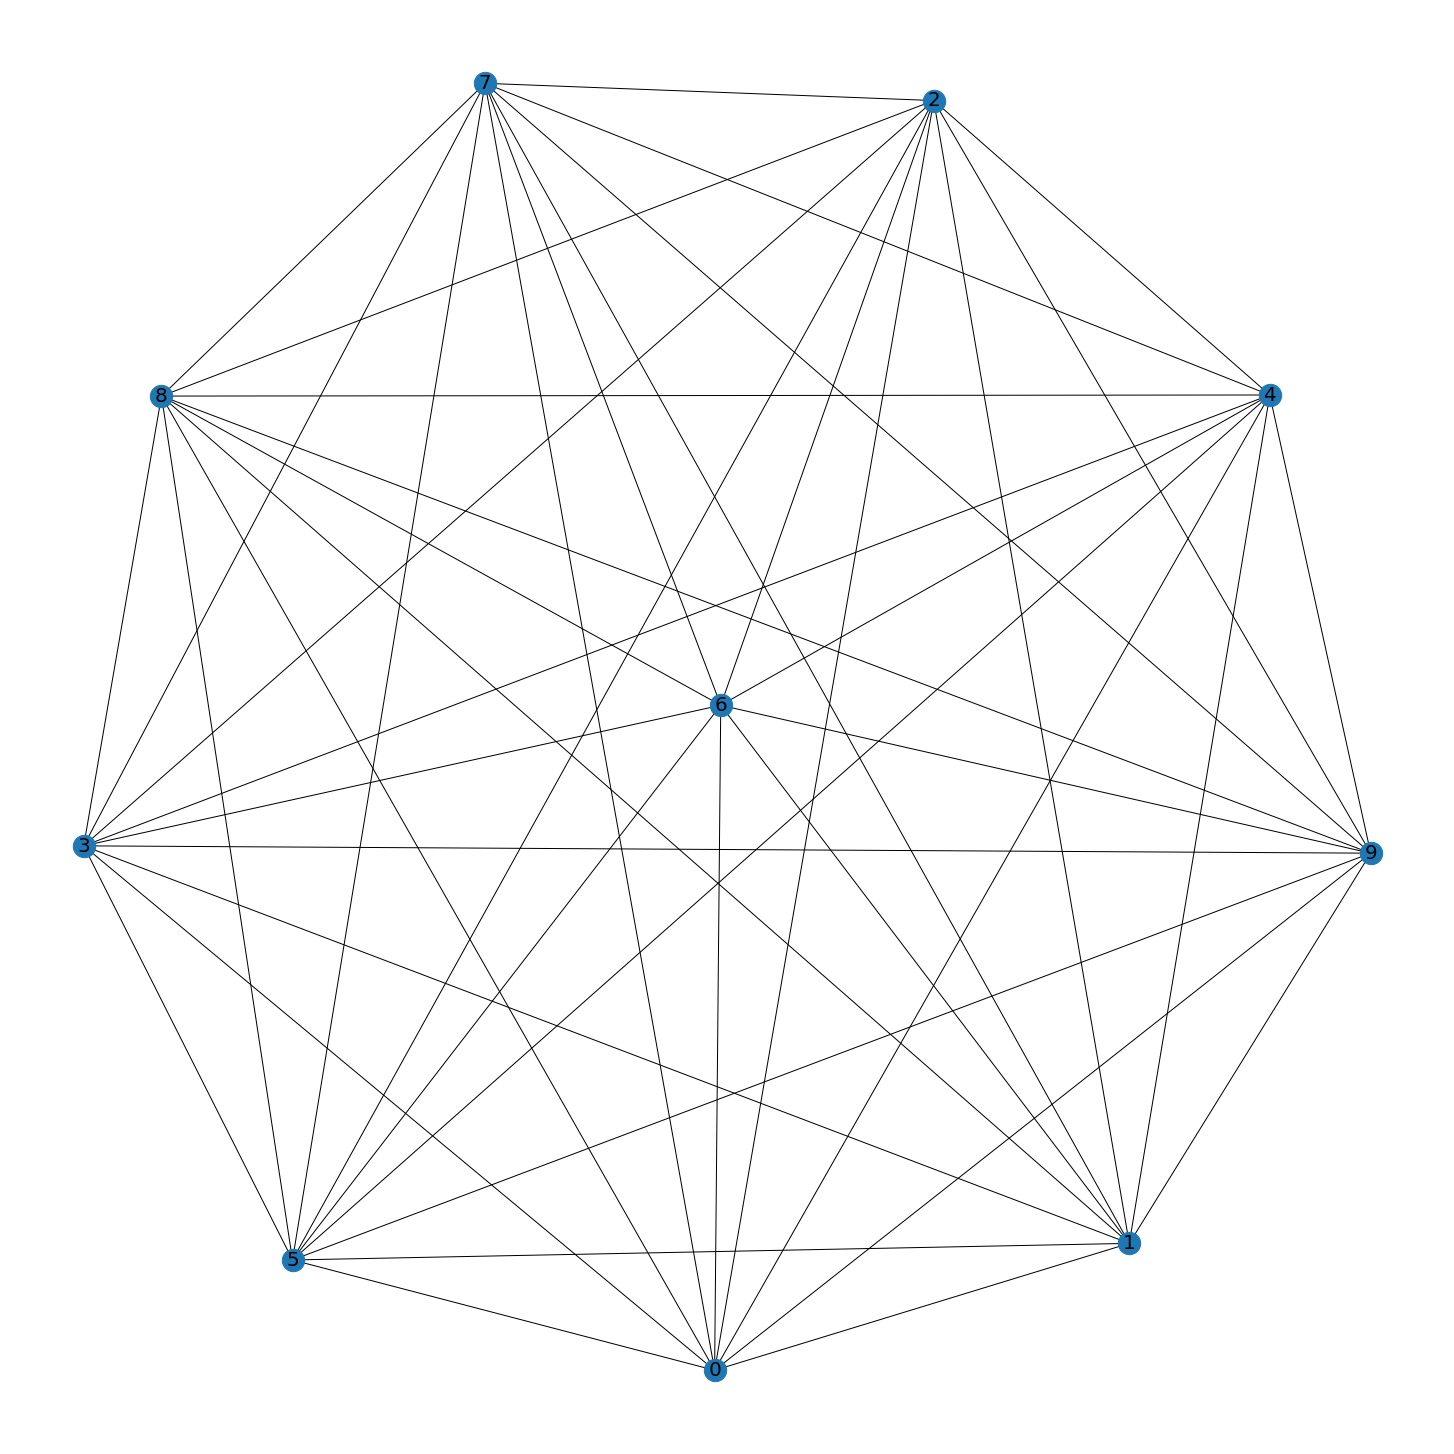

sovling with D-Wave
sovled in  0.8519370555877686 s


/home/matthias/Documents/dsenv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


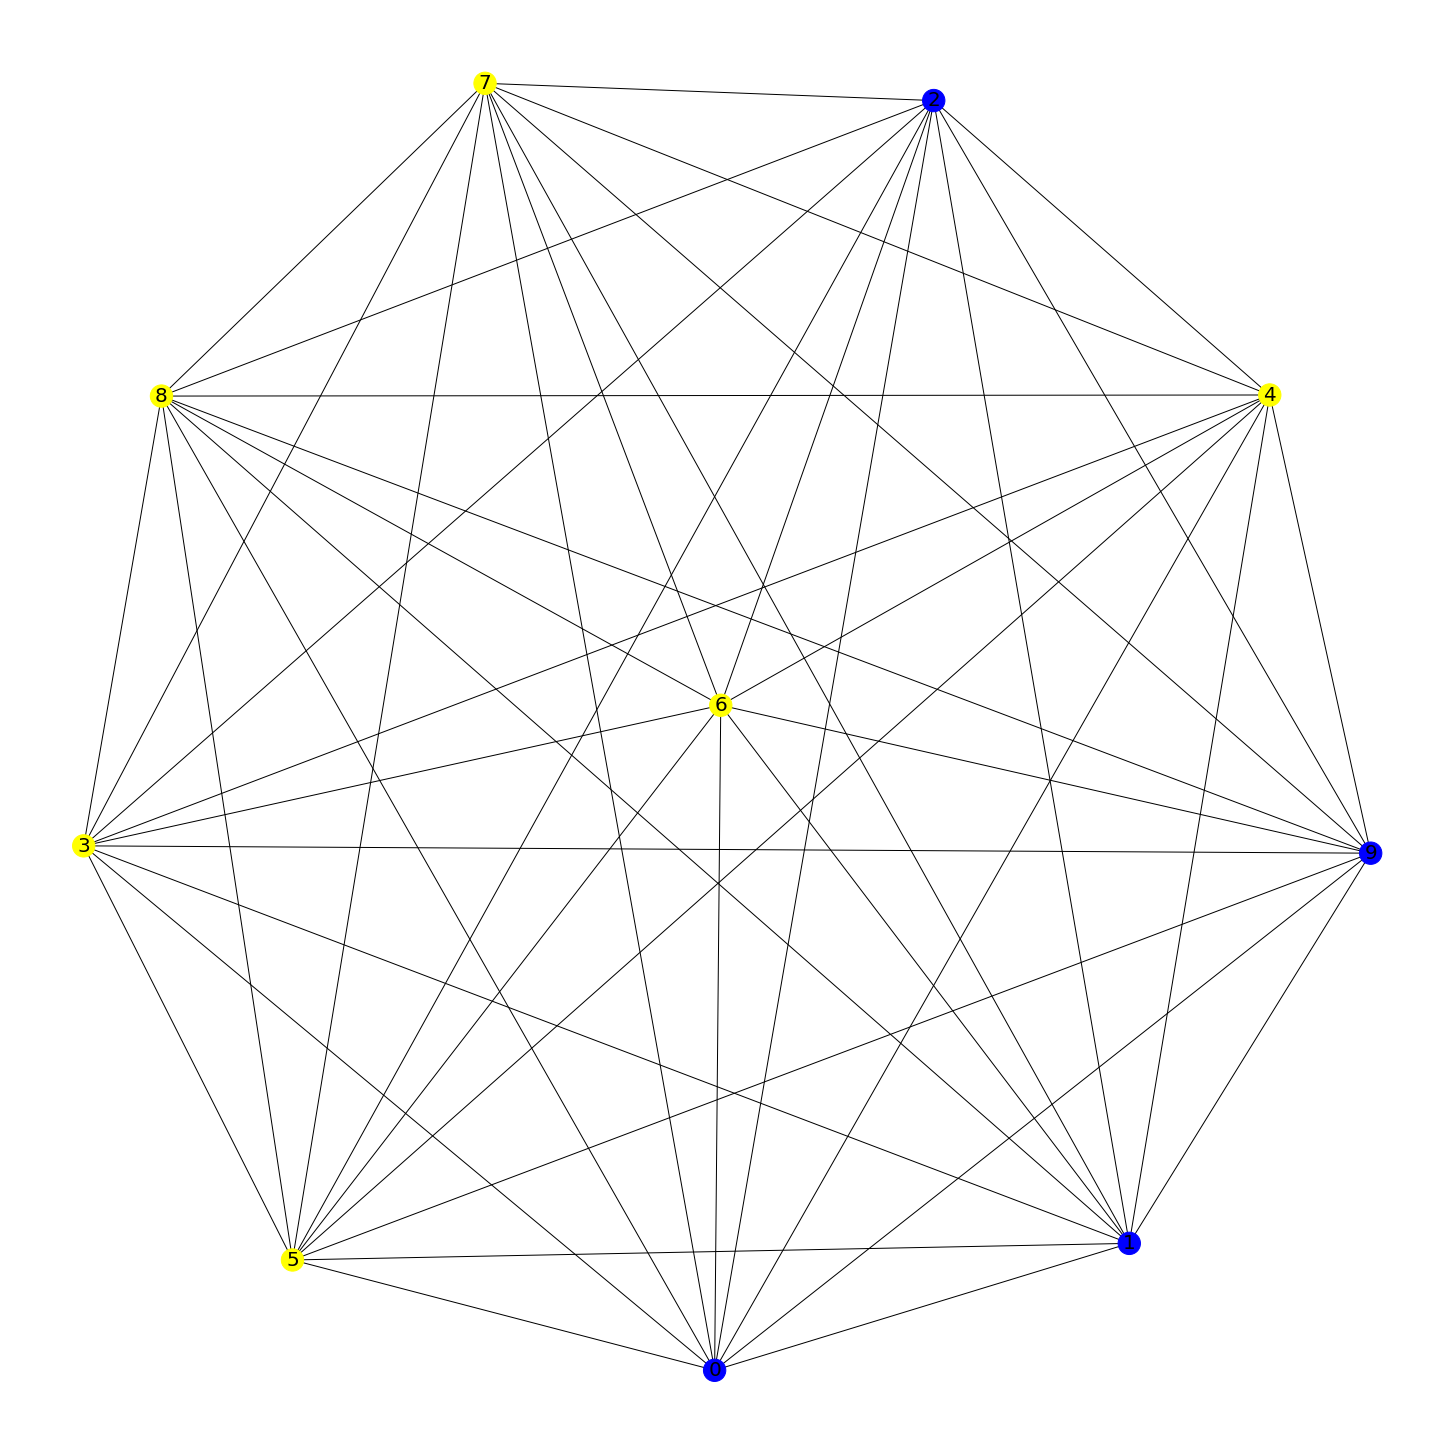

In [5]:
# Use NetworkX graphic package and Python's random library to create a randomly signed network

# Create a K4 complete graph (default node labels are indexical from 0)
G = nx.complete_graph(10)
# Randomly assign +1 or -1 relationship signs to all edges. Rename node 0 to Alice, 1 to Bob, etc
G.add_edges_from([(u, v, {'sign': 2*random.randint(0,1)-1}) for u, v in G.edges])
# nx.relabel_nodes(G, {0: 'Alice', 1: 'Bob', 2: 'Eve', 3: 'Wally'}, copy=False)

# Print the relationships assigned by the current code execution
# print('Friendly relationships: ', [(x, y) for (x, y, sign) in G.edges(data='sign') if (sign == 1)])
# print('Hostile relationships: ', [(x, y) for (x, y, sign) in G.edges(data='sign') if (sign == -1)])

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G)
nx.draw(G, pos)#, with_labels=True)
nx.draw_networkx_labels(G,pos=pos, font_size=20)
labels = nx.get_edge_attributes(G,'sign')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=20)
nx.draw_networkx_nodes(G,pos,node_size=500)
plt.show()


# sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))  # Some accounts need to replace this line with the next:
sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_2_1', token='DEV-a3ae2d86bfa91d5114e454b0f1431256139b710f'))

# Return a good partition (minimal structural imbalance) and its frustrated edges  
start = time.time()
print('sovling with D-Wave')
imbalance, bicoloring = dnx.structural_imbalance(G, sampler)

end = time.time()
print('sovled in ', end-start, 's')
# Mark the returned frustrated edges and node set (color) on the graph 
for edge in G.edges:
    G.edges[edge]['frustrated'] = edge in imbalance
for node in G.nodes:
    G.nodes[node]['color'] = bicoloring[node]

# Print the relationships for the returned partition
# print('Yellow set: ', [person for (person, color) in bicoloring.items() if (color == 0)])
# print('Blue set: ', [person for (person, color) in bicoloring.items() if (color == 1)])
# print('\nFrustrated relationships: ', list(imbalance.keys()))

# pos = nx.spring_layout(G)

plt.figure(figsize=(20,20))

nx.draw(G, pos)#, with_labels=True)
nx.draw_networkx_labels(G,pos=pos, font_size=20)
labels = nx.get_edge_attributes(G,'frustrated')
node_color = nx.get_node_attributes(G, 'color')
color_map = ['yellow' if color==1 else 'blue'
            for name, color in node_color.items()]

# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=20)
nx.draw_networkx_nodes(G,pos,node_size=500, node_color=color_map)

plt.show()

### Benchmark time complexity

In [6]:
# sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))  # Some accounts need to replace this line with the next:
sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_2_1', token='DEV-a3ae2d86bfa91d5114e454b0f1431256139b710f'))

In [77]:
# Use NetworkX graphic package and Python's random library to create a randomly signed network

anneal_times = []

max_nodes = 61
d_nodes = 5

for n_nodes in range(1, max_nodes+1, d_nodes):
    print('solving with {} nodes'.format(n_nodes))
    # Create a K4 complete graph (default node labels are indexical from 0)
    G = nx.complete_graph(n_nodes)
    # Randomly assign +1 or -1 relationship signs to all edges. Rename node 0 to Alice, 1 to Bob, etc
    G.add_edges_from([(u, v, {'sign': 2*random.randint(0,1)-1}) for u, v in G.edges])

    # Return a good partition (minimal structural imbalance) and its frustrated edges  
    start = time.time()
    imbalance, bicoloring = dnx.structural_imbalance(G, sampler)
    end = time.time()
    
    anneal_times.append(end-start)

solving with 1 nodes
solving with 6 nodes
solving with 11 nodes
solving with 16 nodes
solving with 21 nodes
solving with 26 nodes
solving with 31 nodes
solving with 36 nodes
solving with 41 nodes
solving with 46 nodes
solving with 51 nodes
solving with 56 nodes
solving with 61 nodes


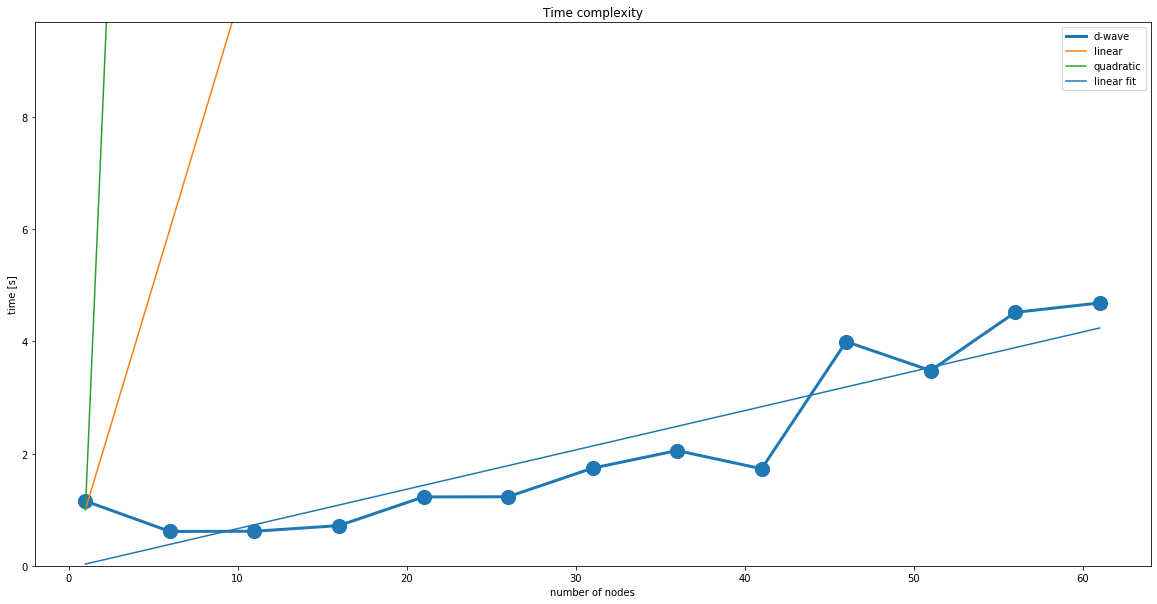

In [82]:
plt.figure(figsize=(20,10))

# plot results of anneals
plt.scatter(range(1, max_nodes+1, d_nodes), anneal_times, s=200, color='tab:blue')
plt.plot(range(1, max_nodes+1, d_nodes), anneal_times, linewidth = 3, c='tab:blue', label='d-wave')

# plot linear time
y = [i for i in range(1, max_nodes+1, d_nodes)]
plt.plot(range(1, max_nodes+1, d_nodes), y, c='tab:orange', label='linear')

# plot quadratic time
y = [i**2 for i in range(1, max_nodes+1, d_nodes)]
plt.plot(range(1, max_nodes+1, d_nodes), y, c='tab:green', label='quadratic')

# Do linear regression on anneal times
X = [[i] for i in range(1, max_nodes+1, d_nodes)]
Y = anneal_times

lr_fit = LinearRegression(fit_intercept=True, normalize=False).fit(X, Y)

a = lr_fit.coef_
b = lr_fit.intercept_

x = [i for i in range(1, max_nodes+1, d_nodes)]
y = [a*i+b for i in x]

plt.plot(x,y, label='linear fit')

plt.ylim((0, max(anneal_times)+5))
plt.legend()
plt.title('Time complexity')
plt.xlabel('number of nodes')
plt.ylabel('time [s]')
plt.show()

# The maximum number of nodes that can be solved on D-Wave is < 70!!

In [84]:
# Use NetworkX graphic package and Python's random library to create a randomly signed network

anneal_times = []

max_nodes = 71
d_nodes = 5

for n_nodes in range(1, max_nodes+1, d_nodes):
    print('solving with {} nodes'.format(n_nodes))
    # Create a K4 complete graph (default node labels are indexical from 0)
    G = nx.complete_graph(n_nodes)
    # Randomly assign +1 or -1 relationship signs to all edges. Rename node 0 to Alice, 1 to Bob, etc
    G.add_edges_from([(u, v, {'sign': 2*random.randint(0,1)-1}) for u, v in G.edges])

    # Return a good partition (minimal structural imbalance) and its frustrated edges  
    start = time.time()
    imbalance, bicoloring = dnx.structural_imbalance(G, sampler)
    end = time.time()
    print('  -- finished')
    anneal_times.append(end-start)

solving with 1 nodes
  -- finished
solving with 6 nodes
  -- finished
solving with 11 nodes
  -- finished
solving with 16 nodes
  -- finished
solving with 21 nodes
  -- finished
solving with 26 nodes
  -- finished
solving with 31 nodes
  -- finished
solving with 36 nodes
  -- finished
solving with 41 nodes
  -- finished
solving with 46 nodes
  -- finished
solving with 51 nodes
  -- finished
solving with 56 nodes
  -- finished
solving with 61 nodes
  -- finished
solving with 66 nodes


ValueError: no embedding found

# Summary
Structural imbalance for social networks is a problem well suited for solving on the D-Wave system: unlike factoring, where typically large integer variables must be converted to even larger binary variables, this problem's structure of bi-valued variables in a typically sparse graph of quadratic relationships is close to a native Ising problem.

We saw how to mathematically formulate an Ising model to represent this problem using the technique of a penalty model, which is used to solve a wide variety of optimization problems on the quantum computer. We then used Ocean tools to formulate the problem and submit it for solution.   

Finally, the following cell attempts to calculate structural imbalance on the entire data set of the Stanford Militants Mapping Project, which has over 200 variables. Consider the following:

* Minor-embedding, performed by the *EmbeddingComposite()* composite, is heuristic and **might fail for a particular run**. If your submission fails, try running the cell again or cut the number of nodes a little closer to 200.
* The heuristic minor-embedding used by this code might not reliably represent such a large problem, and consequently solutions might not be optimal. Embedding such problems requires more advanced techniques that are beyond the scope of this demo.  

For a submission on June 4, 2018 (238 variables in the database), the minor-embedding of the entire database required about half the QPU's qubits:

<img src="images/EmbeddingFullDB.png" width=400x/>

Ocean software provides tools for formulating many types of problems for solution on a QPU and the D-Wave documentation describes various techniques for formulating problems. Check out D-Wave's Ocean suite of tools on [GitHub](https://github.com/dwavesystems) and  [Read the Docs](https://docs.ocean.dwavesys.com/en/latest/).     